In [1]:
import pandas as pd
import traceback

from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

from time import sleep

import re

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
BANK_SCRIPS = ['HDFCBANK','ICICIBANK','AXISBANK','KOTAKBANK','SBIN','CANBK']
IT_SCRIPS = ['INFY', 'HCLTECH','LTIM', 'TCS','LTTS', 'WIPRO' ]
# IT_SCRIPS = ['OLECTRA','KIRLOSBROS','MAZDOCK','JBMA','GLENMARK','ZENTEC','FACT','APARINDS','NEULANDLAB','RKFORGE','TITAGARH','ZENSARTECH' ]
# IT_SCRIPS = ['OLECTRA']
SCRIPS = IT_SCRIPS

## Login

In [3]:
import requests

LOGIN_URL = 'https://www.screener.in/login/'
headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36'
}

response = requests.get(LOGIN_URL, headers=headers, verify=False)
headers['cookie'] = '; '.join([x.name + '=' + x.value for x in response.cookies])
headers['content-type'] = 'application/x-www-form-urlencoded'
headers

{'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
 'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36',
 'cookie': 'csrftoken=zMukpWf2vKUr755bxHCtat16Qz8jHoPv',
 'content-type': 'application/x-www-form-urlencoded'}

## Trying with login

In [4]:
payload = {
    'username': 'Jeevan2961@gmail.com',
    'password': 'Screener@6562!'
}

response = requests.post(LOGIN_URL, data=payload, headers=headers, verify=False)
headers['cookie'] = '; '.join([x.name + '=' + x.value for x in response.cookies])

In [5]:
import requests

url = "https://www.screener.in/login/?csrftoken="

payload = {
    'username': 'Jeevan2961@gmail.com',
    'password': 'Screener@6562!'
}
headers = {
  'Cookie': 'csrftoken=QgS5auLp8rXExwxR6Tladmx3gEDa9aOV'
}

response = requests.request("GET", url, headers=headers, data=payload)


In [6]:
import sys
import requests

URL = 'https://www.screener.in/login/'

client = requests.session()

# Retrieve the CSRF token first
client.get(URL)  # sets cookie
if 'csrftoken' in client.cookies:
    csrftoken = client.cookies['csrftoken']
else:
    # older versions
    csrftoken = client.cookies['csrf']

login_data = dict(username="Jeevan2961@gmail.com", password="Screener@6562!", csrfmiddlewaretoken=csrftoken, next='/')
r = client.post(URL, data=login_data, headers=dict(Referer=URL))

In [7]:
r.cookies

<RequestsCookieJar[Cookie(version=0, name='csrftoken', value='q6eSfQBMaMMGdbhA34rPUo7m8ZLu88Om', port=None, port_specified=False, domain='www.screener.in', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=True, expires=1724402581, discard=False, comment=None, comment_url=None, rest={'SameSite': 'Lax'}, rfc2109=False)]>

# WEB SCRAPING

In [14]:
def extract_table_by_class(soup, section_id, class_name):
    section_html = soup.find('section',{'id': section_id})
    table_html = section_html.find('table',{'class': class_name})

    headers = []
    for header in table_html.find_all('th'):
        headers.append(  header.text or 'Type')

    table_df = pd.DataFrame(columns = headers)

    for row_element in table_html.find_all('tr')[1:]:
            row_data = row_element.find_all('td')
            row = [tr.text.strip() for tr in row_data]
            length = len(table_df)
            table_df.loc[length] = row 
            
    return table_df
    

def fetch_number_span(list_element):
    num_span = list_element.find('span',{'class':'number'})

    num_span = num_span.text.replace(',', '')
    return float(num_span) if (num_span != '') else 0.0
    
def extract_scrip_ratios(soup,div_class, ul_id):
    div_html = soup.find('div',{'class': div_class})
    ul_html = div_html.find('ul',{'id': ul_id})
    current_price = 0
    high = 0.0
    low = 0.0
    dividend_yield = 0.0
    pe = 0.0
    roe = 0.0
    roce = 0.0
    market_cap = 0.0
     
    scrip_data = pd.Series()
    
    for li in ul_html.find_all("li"):
        name_span = li.find('span',{'class':'name'})
        
        if 'Current Price' in name_span.text: 
            current_price = fetch_number_span(li)

        if 'High / Low' in name_span.text:
            num_spans = li.find_all('span',{'class':'number'})
            if(len(num_spans) == 2):
                high_num = num_spans[0].text.replace(',', '')
                low_num = num_spans[1].text.replace(',', '')
                high = float(high_num) if (high_num != '') else 0.0
                low = float(low_num) if (low_num != '') else 0.0 
                
        if 'Market Cap' in name_span.text: 
            market_cap = fetch_number_span(li)
            
        if 'Stock P/E' in name_span.text:
            pe = fetch_number_span(li) 
            
        if 'Dividend Yield' in name_span.text:
            dividend_yield = fetch_number_span(li) 
            
        if 'ROCE' in name_span.text:
            roce = fetch_number_span(li) 
            
        if 'ROE' in name_span.text:
            roe = fetch_number_span(li) 
        
        # if 'Book Value' in name_span.text: 
        #     book_value = fetch_number_span(li)
            
        # if 'Face Value' in name_span.text:
        #     face_value = fetch_number_span(li)
        
        if 'Return on equity' in name_span.text:
            equity_return = fetch_number_span(li) 
            
        # if 'Debt to equity' in name_span.text:
        #     debt_equity = fetch_number_span(li) 
            
        # if 'Promoter holding' in name_span.text:
        #     promoter_holding = fetch_number_span(li)

        # if 'ROE 10Yr' in name_span.text:
        #     roe_10yr = fetch_number_span(li) 

        # if 'EPS' in name_span.text:
        #     eps = fetch_number_span(li) 

        # if 'EPS last year' in name_span.text:
        #     eps_last_year = fetch_number_span(li) 

        # if 'PEG Ratio' in name_span.text:
        #     peg_ratio = fetch_number_span(li) 

        # if 'EPS preceding year' in name_span.text:
        #     eps_preceding_year = fetch_number_span(li) 

        # if 'Debt' in name_span.text:
        #     debt = fetch_number_span(li) 

        # if 'Change in Prom Hold' in name_span.text:
        #     prom_hold_change = fetch_number_span(li) 

        # if 'Industry PE' in name_span.text:
        #     industy_pe = fetch_number_span(li) 

        # if 'Sales growth' in name_span.text:
        #     sales_growth = fetch_number_span(li) 

        # if 'Profit growth' in name_span.text:
        #     profit_growth = fetch_number_span(li) 

        # if 'Price to Sales' in name_span.text:
        #     price_sales = fetch_number_span(li) 


    scrip_data['Price'] = current_price
    scrip_data['High'] = high
    scrip_data['Low'] = low
    scrip_data['Market_Cap'] = market_cap
    scrip_data['PE'] = pe
    scrip_data['Dividend'] = dividend_yield
    scrip_data['ROCE'] = roce
    scrip_data['ROE'] = roe
    # scrip_data['Book_Value'] = book_value
    # scrip_data['Face_Value'] = face_value
    scrip_data['Return_on_equity'] = equity_return
    # scrip_data['Debt_to_equity'] = debt_equity
    # scrip_data['Promoter_holding'] = promoter_holding
    # scrip_data['ROE_10Yr'] = roe_10yr
    # scrip_data['EPS'] = eps
    # scrip_data['EPS_last_year'] = eps_last_year
    # scrip_data['PEG_Ratio'] = peg_ratio
    # scrip_data['EPS_preceding_year'] = eps_preceding_year
    # scrip_data['Debt'] = debt
    # scrip_data['Change_in_Prom_Hold'] = prom_hold_change
    # scrip_data['Industry_PE'] = industy_pe
    # scrip_data['Sales_growth'] = sales_growth
    # scrip_data['Profit_growth'] = profit_growth
    # scrip_data['Price_to_Sales'] = price_sales
    return scrip_data


BASE_URL = 'https://www.screener.in/company/'
def fetch_scrip_data(scrip, section_id):
    link = f'{BASE_URL}{scrip}/consolidated'
    hdr = {'User-Agent':'Mozilla/5.0','Cookie':'csrftoken=aBzLK9SjsMFB5gGaKe7DyZTfmJaFW9tN; sessionid=begnh82711zxs3231mj7acxo5tk4mcab'}
    req = Request(link,headers=hdr)
    
    table_df = None
    scrip_data = pd.Series()
    try:
        page=urlopen(req)
        soup = BeautifulSoup(page)
        # print(soup)
        scrip_data = extract_scrip_ratios(soup,'company-ratios', 'top-ratios')
        try:
            table_df = extract_table_by_class(soup, section_id, 'data-table responsive-text-nowrap')
        except:
            table_df = extract_table_by_class(soup, section_id, 'data-table')
    except:
        print(f'EXCEPTION THROWN: UNABLE TO FETCH DATA')

    return scrip_data, table_df


def extract_last_n_years_pl(pl_df, n_years):
    # Extract data for all years from the column names
    mon_year_regex = re.compile('([A-Z][a-z]{2}) (\d{4})')
    years = {}
    for col in list(pl_df.columns):
        res = re.search(mon_year_regex,col)
        if res:
            years[res.group(2)] = col

    # Get only the last n (PROFIT_LOSS_YEARS) years for checking the P&L 
    years_list = sorted(years.keys())
    years_list = years_list[-n_years:]
    cols = [years[year] for year in years_list]
    pl_values = pl_df[cols].iloc[0, :].values.tolist()
    pl_values = [float(x.replace(',', '')) for x in pl_values] 
    return pl_values

In [15]:
scrip_data, profit_loss_df = fetch_scrip_data('TCS', 'profit-loss')
scrip_data

EXCEPTION THROWN: UNABLE TO FETCH DATA


Series([], dtype: float64)

# CHECK IF CURRENT PRICE IS BELOW PREVIOUS HIGH

In [24]:
# Check if current price is below the 52-week high with a certain threshold
# Eg: If current price is 100, 52-week high is 120, threshold is 10%, then return True
#     If current price is 100, 52-week high is 105, threshold is 10%, then return False
def check_current_below_high_threshold(current,high, threshold_percent):
    below_threshold = False
    if ((current < high) & ((high-current)/high*100 > threshold_percent)):
        below_threshold = True
    return below_threshold   

# PROFIT/LOSS BASED STRATEGY

STRATEGY:

BUY recommendation if:
1. Net profit for the company has been increasing consistently in the last few (config) years
2. Current market price is atleast 10% below the 52-week high (stock is not trading around all time high)

In [25]:
# PROFIT-LOSS STRATEGY - CONFIG
PROFIT_LOSS_YEARS = 3
SCREENER_ROW_PL = 'Net Profit +' # or can be 'Profit before tax'
CURRENT_HIGH_THRESHOLD_PERCENT = 10

In [26]:
def apply_pl_strategy(scrip, current_price, scrip_high, profit_loss_df, high_threshold_percent):
    
#     STRATEGY:
#     BUY recommendation if:
#         1. Profit/Loss for the company has been increasing consistently in the last few years.
#         2. Current market price is below 10% of 52-week high

    # SET DEFAULT TO STOCK AS NO-ACTION
    strategy_result = 'WAIT'
    try: 

        # CHECK IF REQUIRED VALUES COULD BE SCRAPED
        if (current_price is None or current_price == 0.0 or 
            scrip_high is None or scrip_high == 0.0):
            strategy_result = 'NOT FOUND'

        else:
            profit_loss_df = profit_loss_df[profit_loss_df['Type'] == SCREENER_ROW_PL]
            last_pl_list = extract_last_n_years_pl(profit_loss_df, PROFIT_LOSS_YEARS)
            print(f'Profit/Loss for last {PROFIT_LOSS_YEARS} years:{last_pl_list}')
            print(f'Current Price:{current_price}, 52-week High:{scrip_high}, Threshold%: {high_threshold_percent}%')

            # CHECK IF PROFIT-LOSS IS CONSISTENTLY INCREASING
            if(last_pl_list == sorted(last_pl_list)):
                # IF YES, CHECK IF CURRENT MARKET VALUE IS NOT AT ALL TIME HIGH
                if check_current_below_high_threshold(current_price, scrip_high, high_threshold_percent):
                    # BUY RECOMMENDATION
                    strategy_result = 'BUY'
    except Exception as e:
        print(f"UNABLE TO APPLY PROFIT-LOSS STRATEGY ON {scrip}. Exception: {e}")
        print(traceback.format_exc())

    return strategy_result

# SCRAPE THE DATA

In [27]:
final_df = pd.DataFrame({'Symbol':SCRIPS},
                        columns=['Symbol','Market_Cap','Price','High','Low','PE','ROE','ROCE','Dividend','STRATEGY_PL']).set_index('Symbol')


# LOOP THROUGH EACH SCRIP
for scrip in SCRIPS:
    print(f"\nSYMBOL: {scrip}")
    scrip_data, profit_loss_df = fetch_scrip_data(scrip, 'profit-loss')
    for index, value in scrip_data.iteritems():
        final_df[index][scrip] = value
    strategy_result = apply_pl_strategy(scrip, scrip_data['Price'], scrip_data['High'], profit_loss_df, CURRENT_HIGH_THRESHOLD_PERCENT)
    print(f"APPLYING PROFIT/LOSS STRATEGY ON {scrip}: {strategy_result}")
    final_df['STRATEGY_PL'][scrip] = strategy_result
    #sleep(2) # Add sleep if TOO MANY REQUESTS error (Error Code: 429) is thrown

display(final_df)


SYMBOL: INFY
Profit/Loss for last 3 years:[19423.0, 22146.0, 24108.0]
Current Price:1424.0, 52-week High:1673.0, Threshold%: 10%
APPLYING PROFIT/LOSS STRATEGY ON INFY: BUY

SYMBOL: HCLTECH
Profit/Loss for last 3 years:[11169.0, 13523.0, 14845.0]
Current Price:1171.0, 52-week High:1203.0, Threshold%: 10%
APPLYING PROFIT/LOSS STRATEGY ON HCLTECH: WAIT

SYMBOL: LTIM
Profit/Loss for last 3 years:[1938.0, 3950.0, 4410.0]
Current Price:5170.0, 52-week High:5430.0, Threshold%: 10%
APPLYING PROFIT/LOSS STRATEGY ON LTIM: WAIT

SYMBOL: TCS
Profit/Loss for last 3 years:[32562.0, 38449.0, 42303.0]
Current Price:3389.0, 52-week High:3575.0, Threshold%: 10%
APPLYING PROFIT/LOSS STRATEGY ON TCS: WAIT

SYMBOL: LTTS
Profit/Loss for last 3 years:[666.0, 961.0, 1174.0]
Current Price:4380.0, 52-week High:4427.0, Threshold%: 10%
APPLYING PROFIT/LOSS STRATEGY ON LTTS: WAIT

SYMBOL: WIPRO
Profit/Loss for last 3 years:[10868.0, 12243.0, 11366.0]
Current Price:412.0, 52-week High:426.0, Threshold%: 10%
APPLYI

,Market_Cap,Price,High,Low,PE,ROE,ROCE,Dividend,STRATEGY_PL
Symbol,,,,,,,,,
INFY,591323.0,1424.0,1673.0,1185.0,24.0,31.8,40.7,2.39,BUY
HCLTECH,317932.0,1171.0,1203.0,876.0,21.1,23.0,28.3,4.1,WAIT
LTIM,152989.0,5170.0,5430.0,4120.0,34.3,28.6,37.7,1.16,WAIT
TCS,1239979.0,3389.0,3575.0,2926.0,28.3,46.9,59.1,1.4,WAIT
LTTS,46289.0,4380.0,4427.0,3216.0,37.4,25.0,32.8,1.02,WAIT
WIPRO,226465.0,412.0,426.0,352.0,19.5,15.9,17.7,0.24,WAIT


# MARKET CAPITALIZATION PLOT

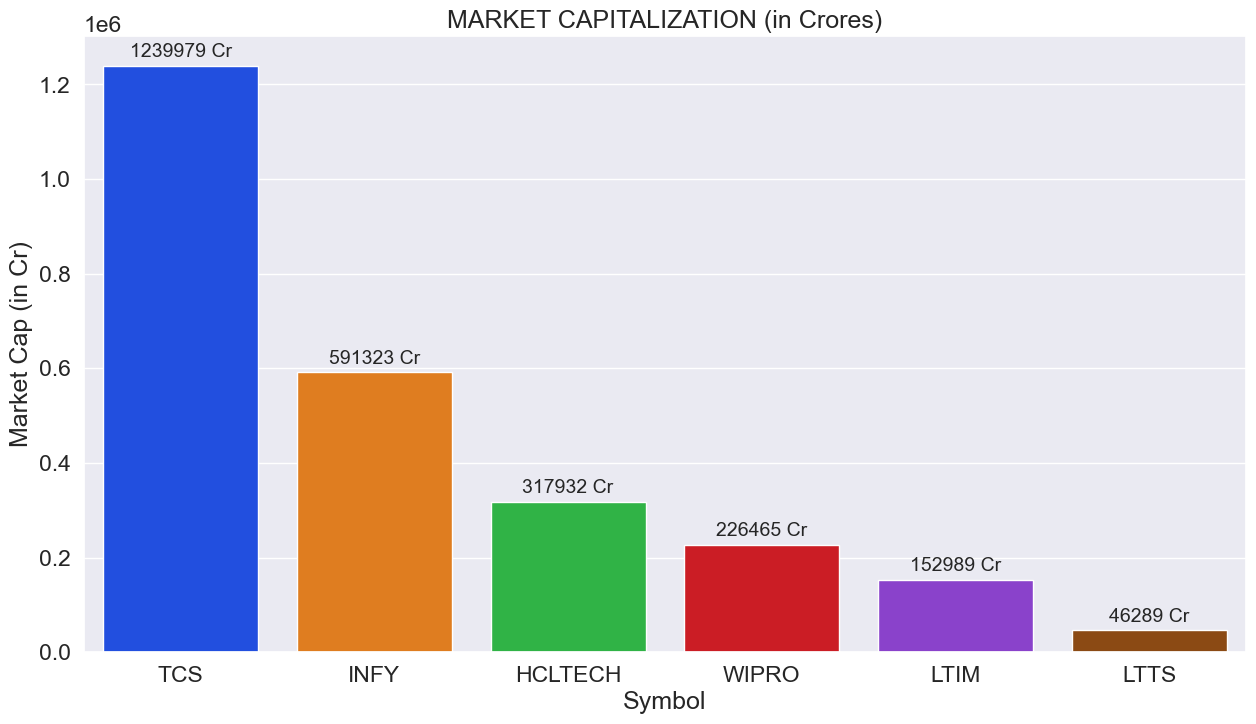

In [28]:
plt.figure(figsize = (15,8))

mark_cap_sorted_df = final_df.sort_values(by='Market_Cap', ascending = False)
ax = sns.barplot(x=mark_cap_sorted_df.index, y=mark_cap_sorted_df['Market_Cap'], palette = 'bright')
ax.set(xlabel="Symbol", ylabel='Market Cap (in Cr)',title = f'MARKET CAPITALIZATION (in Crores)') 
sns.set(font_scale = 1.5)

#annotate axis = seaborn axis
for p in ax.patches:
     ax.annotate("%.0f Cr" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=14,  xytext=(0, 10),
         textcoords='offset points')

# PLOT THE RESULT OF APPLYING THE PROFIT-LOSS STRATEGY

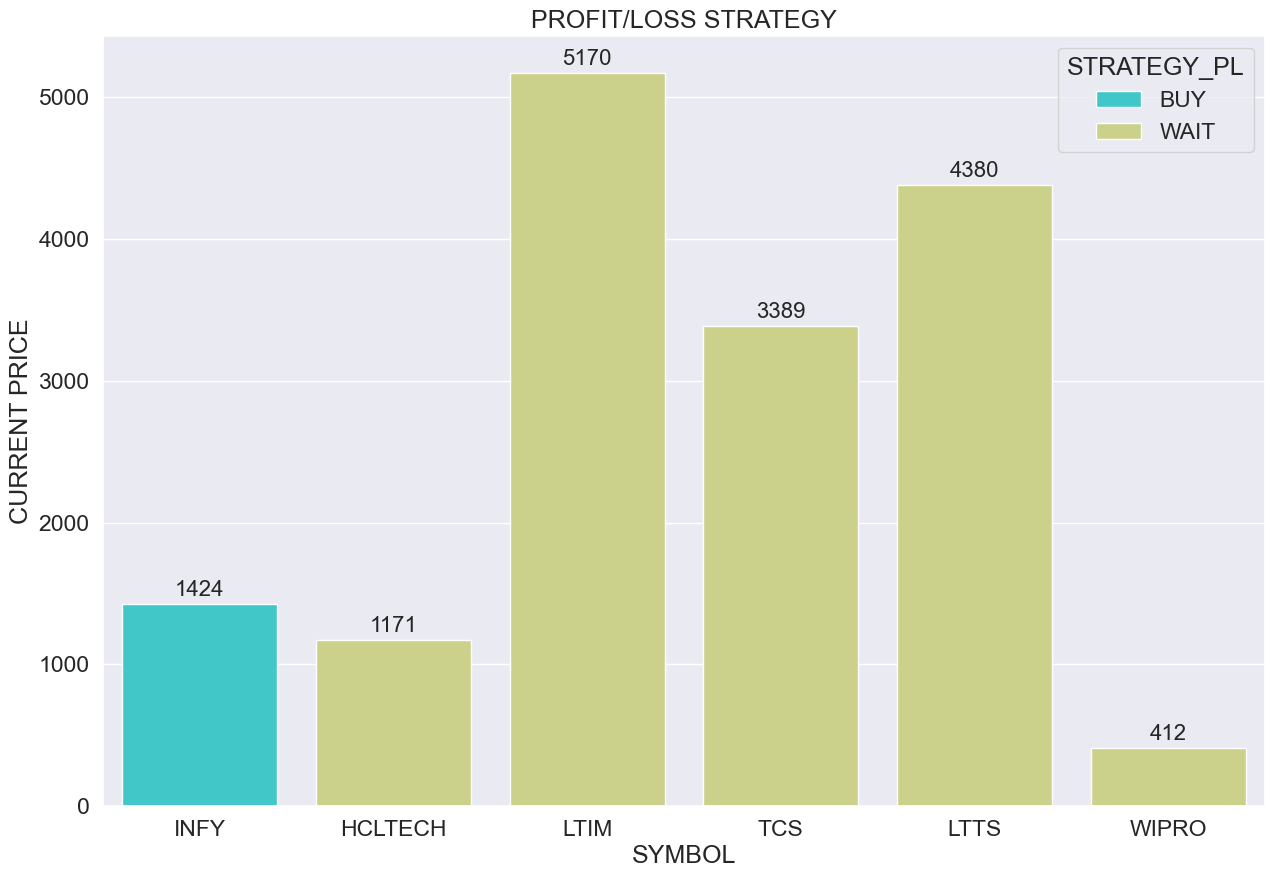

In [29]:
fig = plt.subplots(figsize=(15,10))
ax = sns.barplot(x=final_df.index,y=final_df['Price'],hue=final_df['STRATEGY_PL'],palette='rainbow', dodge=False) 
ax.set(xlabel='SYMBOL', ylabel='CURRENT PRICE', title = 'PROFIT/LOSS STRATEGY')
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=16,  xytext=(0, 10),
                 textcoords='offset points')

sns.set(font_scale = 1.5)
plt.show()

# PE - ROE - ROCE COMPARISON PLOT

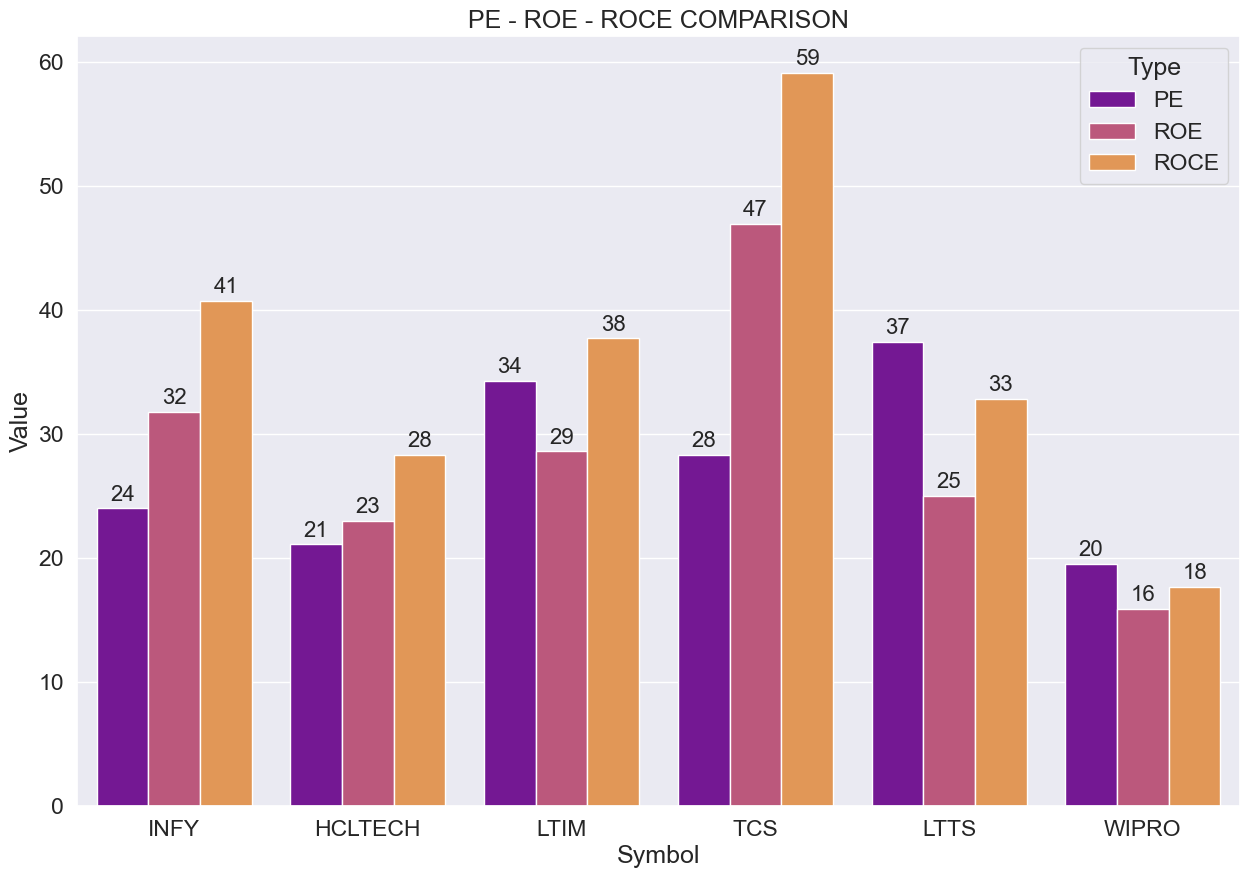

In [30]:
roe_data = pd.DataFrame(final_df['ROE']).rename(columns = {'ROE':'Value'})
roe_data['Type'] = 'ROE'

roce_data = pd.DataFrame(final_df['ROCE']).rename(columns = {'ROCE':'Value'})
roce_data['Type'] = 'ROCE'



pe_data = pd.DataFrame(final_df['PE']).rename(columns = {'PE':'Value'})
pe_data['Type'] = 'PE'

analysis_df = pd.concat([pe_data, roe_data,roce_data])
analysis_df

fig = plt.subplots(figsize=(15,10))

ax = sns.barplot(x=analysis_df.index,
           y=analysis_df['Value'],
           hue=analysis_df['Type'],
           palette = 'plasma')
ax.set( title = 'PE - ROE - ROCE COMPARISON')

for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=16,  xytext=(0, 10),
                 textcoords='offset points')
        
plt.show()

# SAMPLE: EXTRACT THE MARKET CAP OF INFOSYS

In [31]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

SCRIP = 'INFY'
link = f'https://www.screener.in/company/{SCRIP}'
hdr = {'User-Agent':'Mozilla/5.0'}
req = Request(link,headers=hdr)
 
try:
    page=urlopen(req)
    soup = BeautifulSoup(page)
    
    div_html = soup.find('div',{'class': 'company-ratios'})
    ul_html = div_html.find('ul',{'id': 'top-ratios'})
    market_cap = 0.0
        
    for li in ul_html.find_all("li"):
        name_span = li.find('span',{'class':'name'})
        if 'Market Cap' in name_span.text: 
            num_span = li.find('span',{'class':'number'})
            num_span = num_span.text.replace(',', '')
            market_cap = float(num_span) if (num_span != '') else 0.0
    
    print(f'MARKET CAPITILIZATION - {SCRIP}: {market_cap} Cr')

except:
    print(f'EXCEPTION THROWN: UNABLE TO FETCH DATA FOR {SCRIP}')

MARKET CAPITILIZATION - INFY: 591323.0 Cr


# Saving Fundamental Tables in csv

In [14]:
section_id = ['profit-loss', 'balance-sheet', 'quarters', 'cash-flow', 'ratios']
for scrip in SCRIPS:
    print(f"\nSYMBOL: {scrip}")
    for sec_id in section_id:
        scrip_data, df = fetch_scrip_data(scrip, sec_id)
        if df is not None:
            # Remove '\n' and strip leading/trailing spaces from column names
            df.columns = df.columns.str.replace('\n', ' ').str.strip()
            file_name = f"Fundamental_data/{scrip}_{sec_id}.csv"
            df.to_csv(file_name, index=False)
            print(f"Data saved to {file_name}")
        else:
            print(f"No data available for {scrip} - {sec_id}")
    sleep(3)


SYMBOL: INFY
Data saved to Fundamental_data/INFY_profit-loss.csv
Data saved to Fundamental_data/INFY_balance-sheet.csv
Data saved to Fundamental_data/INFY_quarters.csv
Data saved to Fundamental_data/INFY_cash-flow.csv
Data saved to Fundamental_data/INFY_ratios.csv

SYMBOL: HCLTECH
Data saved to Fundamental_data/HCLTECH_profit-loss.csv
Data saved to Fundamental_data/HCLTECH_balance-sheet.csv
Data saved to Fundamental_data/HCLTECH_quarters.csv
Data saved to Fundamental_data/HCLTECH_cash-flow.csv
Data saved to Fundamental_data/HCLTECH_ratios.csv

SYMBOL: LTIM
Data saved to Fundamental_data/LTIM_profit-loss.csv
Data saved to Fundamental_data/LTIM_balance-sheet.csv
Data saved to Fundamental_data/LTIM_quarters.csv
Data saved to Fundamental_data/LTIM_cash-flow.csv
Data saved to Fundamental_data/LTIM_ratios.csv

SYMBOL: TCS
Data saved to Fundamental_data/TCS_profit-loss.csv
Data saved to Fundamental_data/TCS_balance-sheet.csv
Data saved to Fundamental_data/TCS_quarters.csv
Data saved to Funda

In [13]:
for scrip in SCRIPS:
    print(f"\nSYMBOL: {scrip}")
    scrip_data, df = fetch_scrip_data(scrip, 'shareholding')
    if df is not None:
        # Remove '\n' and strip leading/trailing spaces from column names
        df.columns = df.columns.str.replace('\n', ' ').str.strip()
        file_name = f"Fundamental_data/{scrip}_shareholding.csv"
        df.to_csv(file_name, index=False)
        print(f"Data saved to {file_name}")
    else:
        print(f"No data available for {scrip} - shareholding")


SYMBOL: INFY
Data saved to Fundamental_data/INFY_shareholding.csv

SYMBOL: HCLTECH
Data saved to Fundamental_data/HCLTECH_shareholding.csv

SYMBOL: LTIM
Data saved to Fundamental_data/LTIM_shareholding.csv

SYMBOL: TCS
Data saved to Fundamental_data/TCS_shareholding.csv

SYMBOL: LTTS
Data saved to Fundamental_data/LTTS_shareholding.csv

SYMBOL: WIPRO
Data saved to Fundamental_data/WIPRO_shareholding.csv
